In [46]:
import sys
from typing import List

from sklearn.feature_extraction.text import TfidfVectorizer

from sem_covid.services.model_registry import embedding_registry

sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))
import os

os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import spacy
from gensim.models import KeyedVectors

from sem_covid.adapters.abstract_model import SentenceEmbeddingModelABC
from sem_covid.adapters.embedding_models import (TfIdfSentenceEmbeddingModel, Word2VecEmbeddingModel,
                                                 SpacyTokenizerModel, AverageSentenceEmbeddingModel)

from sklearn.metrics.pairwise import pairwise_distances
from sem_covid import config
from sem_covid.services.store_registry import StoreRegistry, StoreRegistryABC
from sem_covid.services.data_registry import Dataset, LanguageModel
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import plotly.express as px
import concurrent.futures

In [2]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))


def similarity_func(u, v):
    return 1 / (1 + euclidean(u, v))


In [3]:
TEXTUAL_COLUMNS = ['title', 'background_info_description', 'content_of_measure_description',
                   'use_of_measure_description', 'involvement_of_social_partners_description']

In [4]:
DOCUMENT_TEXT = 'text'
DOCUMENT_SEGMENT = 'segment_type'
DOCUMENT_SEGMENT_ID = 'segment_id'
DOCUMENT_SOURCE = 'source'
DOCUMENT_PREPARE_METHOD = 'prepare_method'
DOCUMENT_EMBEDDING = 'embedding'
DOCUMENT_EMBEDDING_METHOD = 'embedding_method'
DOCUMENT_TEXTUAL_COLUMNS = 'textual_columns'
DOCUMENT_EMBEDDINGS_FEATURE_STORE_NAME = 'fs_document_embeddings'

In [5]:
class DocumentEmbeddingPipeline:

    def __init__(self, es_index_name: str, textual_columns: list,
                 embedding_model: SentenceEmbeddingModelABC, embedding_model_name: str,
                 store_registry: StoreRegistryABC, doc_emb_feature_store_name: str,
                 text_limit_chars: int = 5000):
        self.es_index_name = es_index_name
        self.textual_columns = textual_columns
        self.prepared_dataset = None
        self.dataset = None
        self.model = embedding_model
        self.model_name = embedding_model_name
        self.text_limit_chars = text_limit_chars
        self.store_registry = store_registry
        self.doc_emb_feature_store_name = doc_emb_feature_store_name

    def load_documents(self):
        es_index_store = self.store_registry.es_index_store()
        self.dataset = es_index_store.get_dataframe(self.es_index_name)

    def prepare_textual_columns(self):
        assert self.dataset is not None
        self.dataset.dropna(subset=self.textual_columns, inplace=True)
        self.dataset[DOCUMENT_TEXT] = self.dataset[self.textual_columns].agg(lambda texts:
                                                                             ". ".join(texts)[:self.text_limit_chars]
                                                                             , axis=1)
        self.prepared_dataset = pd.DataFrame(self.dataset[DOCUMENT_TEXT])
        self.prepared_dataset[DOCUMENT_SOURCE] = self.es_index_name
        self.prepared_dataset[DOCUMENT_SEGMENT] = 'document'
        self.prepared_dataset[DOCUMENT_SEGMENT_ID] = 0
        self.prepared_dataset[DOCUMENT_PREPARE_METHOD] = 'join_textual_columns'
        self.prepared_dataset[DOCUMENT_TEXTUAL_COLUMNS] = [self.textual_columns] * len(self.prepared_dataset)

    def compute_embeddings(self):
        assert self.model is not None
        assert self.prepared_dataset is not None
        self.prepared_dataset[DOCUMENT_EMBEDDING] = self.model.encode(
            self.prepared_dataset[DOCUMENT_TEXT].tolist())
        self.prepared_dataset[DOCUMENT_EMBEDDING_METHOD] = self.model_name

    def store_embeddings(self):
        assert self.prepared_dataset is not None
        assert DOCUMENT_EMBEDDING in self.prepared_dataset.columns
        es_feature_store = self.store_registry.es_feature_store()
        es_feature_store.put_features(features_name=self.doc_emb_feature_store_name,
                                      content=self.prepared_dataset)

    def execute(self):
        self.load_documents()
        self.prepare_textual_columns()
        self.compute_embeddings()
        self.store_embeddings()

In [6]:
tf_ids_sent_emb_model = embedding_registry.sent2vec_tfidf_avg()

In [10]:
document_embedding_pipeline = DocumentEmbeddingPipeline(es_index_name=config.IRELAND_TIMELINE_ELASTIC_SEARCH_INDEX_NAME,
                                                        textual_columns=['title'],
                                                        embedding_model=tf_ids_sent_emb_model
                                                        )
document_embedding_pipeline.execute()

100% (410 of 410) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
N/A% (0 of 407) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

In [8]:
es_store = StoreRegistry.es_feature_store()
df = es_store.get_features(config.EU_CELLAR_ELASTIC_SEARCH_INDEX_NAME)


100% (2811 of 2811) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [55]:
es_store = StoreRegistry.es_index_store()

In [56]:
df = es_store.get_dataframe(index_name=config.PWDB_ELASTIC_SEARCH_INDEX_NAME)

100% (1288 of 1288) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [73]:
df[TEXTUAL_COLUMNS].agg(lambda texts: ". ".join(texts)[:512], axis=1)

'Agreement on a teleworking regime. During the COVID-19 crisis, teleworking has been identified as a vital pillar to keep companies working and prevent social hardship. Discussions between the two representative social partners OGBL and LCGB and the employer association UEL, together with the Ministry of Work and Employment, led in a first instance to a joint assessment on teleworking at the level of the Economic and Social Council CES. From there, discussions continued between the social partners and an int'

In [11]:
feature_store = StoreRegistry.es_feature_store()

In [12]:
df = feature_store.get_features(DOCUMENT_EMBEDDINGS_FEATURE_STORE_NAME)

100% (2514 of 2514) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [49]:
list(set(df.source.values))

['ds_eu_timeline', 'ds_ireland_timeline', 'ds_pwdb', 'ds_eu_cellar']

In [13]:
DATASET_NAMES = ['ds_pwdb', 'ds_eu_cellar', 'ds_eu_timeline', 'ds_ireland_timeline']
document_embeddings = {dataset_name: df[df.source == dataset_name] for dataset_name in DATASET_NAMES}

In [14]:
def generate_similarity_matrix(df_x: pd.DataFrame, df_y: pd.DataFrame, metric):
    return pd.DataFrame(pairwise_distances(X=df_x[DOCUMENT_EMBEDDING].to_list(),
                                           Y=df_y[DOCUMENT_EMBEDDING].to_list(), metric=metric),
                        columns=df_y.index.to_list(),
                        index=df_x.index.to_list()
                        )

In [15]:
def similarity_matrix_to_array(similarity_matrix: np.array):
    return [similarity_matrix[i][j] for i in range(0, similarity_matrix.shape[0])
            for j in range(i + 1, similarity_matrix.shape[1])]

In [16]:
def prepare_eda_data():
    def prepare_worker(name_x: str, name_y: str):
        print(f"start : [{name_x}]x[{name_y}]")
        similarity_matrix = generate_similarity_matrix(document_embeddings[name_x],
                                                       document_embeddings[name_y],
                                                       cosine)
        similarity_list = similarity_matrix_to_array(similarity_matrix.values)
        print(f"finish : [{name_x}]x[{name_y}]")
        return f'[{name_x}]x[{name_y}]', similarity_matrix, similarity_list

    eda_data = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(prepare_worker, name_x, name_y)
                   for name_x in DATASET_NAMES
                   for name_y in DATASET_NAMES[DATASET_NAMES.index(name_x):]]
        eda_data = [future.result() for future in futures]
    return eda_data

In [ ]:
class DocumentsSimilarityPipeline:

    def __init__(self, document_embeddings_index: str, similarity_metric,
                 save_figures_path: str
                 ):
        self.document_embeddings_index = document_embeddings_index
        self.similarity_metric = similarity_metric
        self.prepared_data = None
        self.document_embeddings = {}
        self.dataset_names = []
        self.save_figures_path = save_figures_path

    def load_document_embeddings(self):
        es_store = StoreRegistry.es_index_store()
        tmp_df = es_store.get_dataframe(index_name=self.document_embeddings_index)
        self.dataset_names = list(set(tmp_df.source.values))
        self.document_embeddings = {dataset_name: tmp_df[tmp_df.source == dataset_name]
                                    for dataset_name in self.dataset_names}

    def prepare_similarity_data(self):
        def prepare_worker(name_x: str, name_y: str):
            similarity_matrix = pd.DataFrame(
                pairwise_distances(X=self.document_embeddings[name_x][DOCUMENT_EMBEDDING].to_list(),
                                   Y=self.document_embeddings[name_y][DOCUMENT_EMBEDDING].to_list(),
                                   metric=self.similarity_metric),
                columns=self.document_embeddings[name_y].index.to_list(),
                index=self.document_embeddings[name_x].index.to_list()
            )
            similarity_list = [similarity_matrix[row][col]
                               for row in range(0, similarity_matrix.shape[0])
                               for col in range(row + 1, similarity_matrix.shape[1])]

            return f'[{name_x}]x[{name_y}]', similarity_matrix, similarity_list

        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(prepare_worker, name_x, name_y)
                       for name_x in self.dataset_names
                       for name_y in self.dataset_names[self.dataset_names.index(name_x):]]
            self.prepared_data = [future.result() for future in futures]

    def plot_histograms(self):
        plt.subplots(figsize=(10, 5))
        for data in self.prepared_data:
            plot_title = f"{data[0]} similarity distribution[TfIdfEmbeddingModel]"
            plot = sns.histplot(data=data[2]).set_title(plot_title)
            plot.figure.savefig(self.save_figures_path + plot_title + '.png')
            plot.figure.clf()

In [17]:
prepared_data = prepare_eda_data()

start : [ds_pwdb]x[ds_pwdb]start : [ds_pwdb]x[ds_eu_cellar]

start : [ds_pwdb]x[ds_eu_timeline]
start : [ds_pwdb]x[ds_ireland_timeline]
start : [ds_eu_cellar]x[ds_eu_cellar]
start : [ds_eu_cellar]x[ds_eu_timeline]
start : [ds_eu_cellar]x[ds_ireland_timeline]
start : [ds_eu_timeline]x[ds_eu_timeline]


<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
<ipython-input-2-830c9f64081d>:2: RuntimeWarning: in

start : [ds_eu_timeline]x[ds_ireland_timeline]
start : [ds_ireland_timeline]x[ds_ireland_timeline]
finish : [ds_eu_timeline]x[ds_eu_timeline]
finish : [ds_eu_timeline]x[ds_ireland_timeline]
finish : [ds_eu_cellar]x[ds_eu_timeline]
finish : [ds_ireland_timeline]x[ds_ireland_timeline]
finish : [ds_pwdb]x[ds_eu_timeline]
finish : [ds_eu_cellar]x[ds_ireland_timeline]
finish : [ds_eu_cellar]x[ds_eu_cellar]
finish : [ds_pwdb]x[ds_ireland_timeline]
finish : [ds_pwdb]x[ds_eu_cellar]
finish : [ds_pwdb]x[ds_pwdb]


In [21]:
figures = [
    px.histogram(list(map(lambda x: round(x, 2), data[2])),
                 title=f"{data[0]} similarity distribution.[TfIdfEmbeddingModel]")
    for data in prepared_data
]

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
plt.subplots(figsize=(10, 5))
for data in prepared_data:
    figure_title = f"{data[0]} similarity distribution[TfIdfEmbeddingModel]"
    figure = sns.histplot(data=data[2]).set_title(figure_title)
    figure.figure.savefig('docs/document-similarity/' + figure_title + '.png')
    figure.figure.clf()


<Figure size 720x360 with 0 Axes>

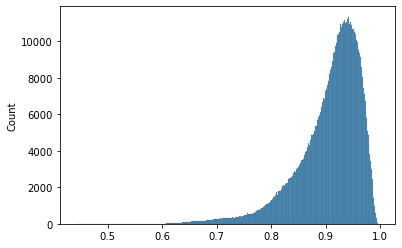

In [20]:
figures[0].write_image()

g


In [80]:
for i in range(0, len(prepared_data)):
    print(i, prepared_data[i][0])

0 [ds_pwdb]x[ds_pwdb]
1 [ds_pwdb]x[ds_eu_cellar]
2 [ds_pwdb]x[ds_eu_timeline]
3 [ds_pwdb]x[ds_ireland_timeline]
4 [ds_eu_cellar]x[ds_eu_cellar]
5 [ds_eu_cellar]x[ds_eu_timeline]
6 [ds_eu_cellar]x[ds_ireland_timeline]
7 [ds_eu_timeline]x[ds_eu_timeline]
8 [ds_eu_timeline]x[ds_ireland_timeline]
9 [ds_ireland_timeline]x[ds_ireland_timeline]


In [83]:
eu_cellar_matrix = prepared_data[4][1]


In [94]:
columns = eu_cellar_matrix.columns.to_list()

eu_cellar_values = eu_cellar_matrix.values

In [99]:
similarity_dub = [(i, j)
                  for i in range(0, eu_cellar_values.shape[0])
                  for j in range(i + 1, eu_cellar_values.shape[1])
                  if eu_cellar_values[i][j] > 0.95]

In [109]:
for index1, index2 in similarity_dub[:10]:
    doc1 = df.loc[eu_cellar_matrix.columns[index1]]['text']
    doc2 = df.loc[eu_cellar_matrix.columns[index2]]['text']
    print(doc1)
    print(doc2)

Authorisation for State aid pursuant to Articles 107 and 108 of the Treaty on the Functioning of the European Union — Cases where the Commission raises no objectionsText with EEA relevance.
Authorisation for State aid pursuant to Articles 107 and 108 of the Treaty on the Functioning of the European Union — Cases where the Commission raises no objectionsText with EEA relevance.
Authorisation for State aid pursuant to Articles 107 and 108 of the Treaty on the Functioning of the European Union — Cases where the Commission raises no objectionsText with EEA relevance.
Authorisation for State aid pursuant to Articles 107 and 108 of the Treaty on the Functioning of the European Union — Cases where the Commission raises no objectionsText with EEA relevance.
Authorisation for State aid pursuant to Articles 107 and 108 of the Treaty on the Functioning of the European Union — Cases where the Commission raises no objectionsText with EEA relevance.
Authorisation for State aid pursuant to Articles 1

In [129]:
es_store = StoreRegistry.es_index_store()
ds_eu_cellar = es_store.get_dataframe(index_name='ds_eu_cellar')

100% (2653 of 2653) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [131]:
ds_eu_cellar

Index(['work', 'title', 'cdm_types', 'cdm_type_labels', 'resource_types',
       'resource_type_labels', 'eurovoc_concepts', 'eurovoc_concept_labels',
       'subject_matters', 'subject_matter_labels', 'directory_codes',
       'directory_codes_labels', 'celex_numbers', 'legal_elis', 'id_documents',
       'same_as_uris', 'authors', 'author_labels', 'full_ojs', 'oj_sectors',
       'internal_comments', 'is_in_force', 'dates_document', 'dates_created',
       'legal_dates_entry_into_force', 'legal_dates_signature', 'manifs_pdf',
       'manifs_html', 'pdfs_to_download', 'htmls_to_download',
       'eu_cellar_core', 'eu_cellar_extended', 'content_path', 'content',
       'language', 'failure_reason'],
      dtype='object')

In [63]:
# for name_x in DATASET_NAMES:
#     for name_y in DATASET_NAMES[DATASET_NAMES.index(name_x):]:
#         similarity_matrix = generate_similarity_matrix(document_embeddings[name_x],
#                                                        document_embeddings[name_y],
#                                                        cosine)
#         similarity_list = similarity_matrix_to_array(similarity_matrix.values)
#         fig = px.histogram(list(map(lambda x: round(x,4),similarity_list)),
#                            title=f"[{name_x}]X[{name_y}] similarity distribution.")
#         fig.show()

hello


In [144]:
import faiss

In [204]:
index = faiss.IndexIDMap(faiss.IndexFlatIP(len(df[DOCUMENT_EMBEDDING][0])))

In [205]:
index.add_with_ids(np.array(df[DOCUMENT_EMBEDDING].to_list()).astype('float32'),
                   np.array(range(0, len(df))))


In [238]:
query = df[DOCUMENT_EMBEDDING].to_list()[2]

In [200]:
df.iloc[3][['text', 'source']]

text      Waiver of advance payments for social and heal...
source                                              ds_pwdb
Name: 18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044, dtype: object

In [199]:
df.iloc[756][['text', 'source']]

text      Postponement of the employers' deadline for pa...
source                                              ds_pwdb
Name: 01a95e4b5c3c887bfd01a05c21b914df2248bd0b68da4785e7dec062bbedfa9e, dtype: object

In [239]:
query

[0.0378753208,
 -0.038546972,
 -0.0331166461,
 -0.0483590327,
 0.022393113,
 0.003940654,
 0.0649666637,
 -0.0591262542,
 -0.0589584373,
 -0.0070893406,
 -0.0574852228,
 0.0394048467,
 0.0607795827,
 -0.0592336655,
 0.0646905378,
 -0.0220377017,
 0.0651763603,
 -0.0132389721,
 -0.059833575,
 -0.0399091952,
 -0.0023563665,
 0.0053202608,
 -0.0181395654,
 0.025766328,
 0.0418812744,
 0.0128296586,
 -0.0468763933,
 -0.0241368003,
 -0.0205882024,
 0.0376288332,
 0.0014298491,
 -0.0611683503,
 0.0250321552,
 -0.0488700345,
 0.0214957725,
 -0.0655383617,
 0.0497455373,
 0.0483916327,
 0.037381243,
 -0.0233520921,
 -0.0035018283,
 0.0493327603,
 0.0558017455,
 -0.0009784676,
 -0.0661733449,
 -0.0507086441,
 -0.0364560001,
 0.005344708,
 -0.0191676207,
 -0.0563165955,
 -0.0657291189,
 -0.021348238,
 -0.0637413561,
 -0.0488439612,
 -0.058114104,
 0.0411729366,
 -0.0649475753,
 -0.0107492562,
 0.0327971205,
 -0.057550054,
 0.0117146475,
 -0.0474368595,
 0.0086091822,
 -0.0650470257,
 -0.01083005

In [240]:
k = 4
D, I = index.search(np.array([query]).astype('float32'), k)
print(I)
print(D)

[[   2 1248  283   79]]
[[0.9999997  0.66516745 0.64820206 0.59296393]]


In [241]:
df.iloc[2][['text', 'source']]


text      Funds for innovative renewable projects in And...
source                                              ds_pwdb
Name: 8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353, dtype: object

In [242]:
df.iloc[1248][['text', 'source']]

text      Green energy for accommodation & food business...
source                                              ds_pwdb
Name: c6da8d58564a47f2dc3062a3c480b10a0cb562c803d2c603dd24cefab0adc7c5, dtype: object

In [214]:
emb_list = df[DOCUMENT_EMBEDDING].tolist()
name_list = df.index.to_list()

In [215]:
sim_matrix = pd.DataFrame(pairwise_distances(emb_list, metric=similarity_func), index=name_list, columns=name_list)
sim_matrix

,adc5c75937bc7f7198f534d08b85bd50c9521bfd3f319a090932b5d0bae54de0,2372d71eb9ad6e6a70982e02bbe802db004ed49d91b2264c0a2e8e41571002cc,8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353,18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044,b94d8aa95fbdeb1bb832b01fbe5d6e9bf9fc36fceb14f7ba370a963f472fe35b,d6897267c1316d4c6be9d6f64332f470e4118225476847bf448abce7ab934145,51fd686c7abd00e1e7b5b31a436a921582b3babe46d1941714b38495ad3fe8ed,c118f163e77cf2c95f981bb2528b821379b5c498eb04ee346babd91d673bf9ec,6e8160a1e50fd0536d4e770490fbcfc20d7e7dc3c65bac762063ac097866947f,6f70ff714553a60e3404d55a941ff47a3e0dd4a9ba5cb9135f3e54f418b3a97f,...,fa25e4c61921862c0310a9802fb459b36b152d51d23ce58f5ec6d0a9251d27c2,fab01840d4d4652594130f3a64de72564dc3a342c516b2560cd7fe29284b82b9,fac3fd4870ae1b04d8c04b750851df65e38b74952c738ca09a5ec3dd9d0eaab1,fb041845214d88926218c03ec39f14e6fb9e46b36d32fa39dab38ce88cae65c3,fb207003cb281a1157be6a5c8580e87d9715c42ad78de4317a0a5b397ef955f3,fb64282022bd7a49e51b2548d2f325a8cbbea756702d619c024cf34c43ec1cfd,fc3912792c86de37ec7f6ffa7a0ce5d5d7b7c86f02ba890cdf0bb85a3628a792,fc8805ee2fd5f28dee01b1172f4ee9d4b3937c8578a92fae6720471685863814,fdd37416fae54311797c08c37956747d741ab86141a64da118c0d3c27a3ca69e,fefa88e8bcb8f19c1794526db7e241a1201a7aa6f05fedd25c09cee4b35c46f0
adc5c75937bc7f7198f534d08b85bd50c9521bfd3f319a090932b5d0bae54de0,1.000000,0.496512,0.453722,0.497151,0.470805,0.533803,0.448236,0.470663,0.454792,0.516943,...,0.411572,0.418112,0.415931,0.420042,0.426732,0.408253,0.421007,0.418130,0.413371,0.415848
2372d71eb9ad6e6a70982e02bbe802db004ed49d91b2264c0a2e8e41571002cc,0.496512,1.000000,0.454741,0.496707,0.476957,0.494780,0.458312,0.466210,0.466761,0.488558,...,0.412700,0.424544,0.418685,0.411672,0.427768,0.419538,0.418824,0.417562,0.417337,0.442441
8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353,0.453722,0.454741,1.000000,0.437009,0.469963,0.447736,0.458513,0.466450,0.449098,0.445912,...,0.417419,0.422373,0.431373,0.414413,0.406727,0.407835,0.410753,0.414804,0.457231,0.442620
18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044,0.497151,0.496707,0.437009,1.000000,0.497571,0.515404,0.481000,0.447983,0.456158,0.467616,...,0.413016,0.415274,0.410590,0.435588,0.434046,0.418540,0.418645,0.419202,0.416171,0.435658
b94d8aa95fbdeb1bb832b01fbe5d6e9bf9fc36fceb14f7ba370a963f472fe35b,0.470805,0.476957,0.469963,0.497571,1.000000,0.502765,0.501329,0.457158,0.468089,0.460835,...,0.406539,0.413325,0.419462,0.421313,0.409925,0.418367,0.415904,0.400579,0.427719,0.421342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb64282022bd7a49e51b2548d2f325a8cbbea756702d619c024cf34c43ec1cfd,0.408253,0.419538,0.407835,0.418540,0.418367,0.434927,0.410787,0.425300,0.436270,0.415307,...,0.441992,0.427747,0.434162,0.425351,0.425368,1.000000,0.409047,0.424939,0.427098,0.412986
fc3912792c86de37ec7f6ffa7a0ce5d5d7b7c86f02ba890cdf0bb85a3628a792,0.421007,0.418824,0.410753,0.418645,0.415904,0.421587,0.420348,0.412778,0.412828,0.419839,...,0.411930,0.408673,0.412979,0.403183,0.408329,0.409047,1.000000,0.423722,0.409164,0.414334
fc8805ee2fd5f28dee01b1172f4ee9d4b3937c8578a92fae6720471685863814,0.418130,0.417562,0.414804,0.419202,0.400579,0.413174,0.420232,0.406998,0.402162,0.422787,...,0.420634,0.421194,0.415561,0.417285,0.444605,0.424939,0.423722,1.000000,0.415707,0.415690
fdd37416fae54311797c08c37956747d741ab86141a64da118c0d3c27a3ca69e,0.413371,0.417337,0.457231,0.416171,0.427719,0.417119,0.418934,0.418683,0.420986,0.411670,...,0.406538,0.441341,0.457365,0.415263,0.418713,0.427098,0.409164,0.415707,1.000000,0.445997


In [219]:
sim_matrix_without_diagonal = sim_matrix

In [220]:
np.fill_diagonal(sim_matrix_without_diagonal.values, -1)

In [231]:
sim_matrix_without_diagonal.max(axis=1).sort_values(ascending=False).values[:1000]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [234]:
sim_matrix.loc[sim_matrix[sim_matrix.columns[0]] > 0.8]

,adc5c75937bc7f7198f534d08b85bd50c9521bfd3f319a090932b5d0bae54de0,2372d71eb9ad6e6a70982e02bbe802db004ed49d91b2264c0a2e8e41571002cc,8735e268191e9e5cbd3d2a44ca53d297e31746b5f1e24b941db6225a25848353,18bcd22116c46919e03a3345f793c3859855227ac942e69dd13cbfcd588e1044,b94d8aa95fbdeb1bb832b01fbe5d6e9bf9fc36fceb14f7ba370a963f472fe35b,d6897267c1316d4c6be9d6f64332f470e4118225476847bf448abce7ab934145,51fd686c7abd00e1e7b5b31a436a921582b3babe46d1941714b38495ad3fe8ed,c118f163e77cf2c95f981bb2528b821379b5c498eb04ee346babd91d673bf9ec,6e8160a1e50fd0536d4e770490fbcfc20d7e7dc3c65bac762063ac097866947f,6f70ff714553a60e3404d55a941ff47a3e0dd4a9ba5cb9135f3e54f418b3a97f,...,fa25e4c61921862c0310a9802fb459b36b152d51d23ce58f5ec6d0a9251d27c2,fab01840d4d4652594130f3a64de72564dc3a342c516b2560cd7fe29284b82b9,fac3fd4870ae1b04d8c04b750851df65e38b74952c738ca09a5ec3dd9d0eaab1,fb041845214d88926218c03ec39f14e6fb9e46b36d32fa39dab38ce88cae65c3,fb207003cb281a1157be6a5c8580e87d9715c42ad78de4317a0a5b397ef955f3,fb64282022bd7a49e51b2548d2f325a8cbbea756702d619c024cf34c43ec1cfd,fc3912792c86de37ec7f6ffa7a0ce5d5d7b7c86f02ba890cdf0bb85a3628a792,fc8805ee2fd5f28dee01b1172f4ee9d4b3937c8578a92fae6720471685863814,fdd37416fae54311797c08c37956747d741ab86141a64da118c0d3c27a3ca69e,fefa88e8bcb8f19c1794526db7e241a1201a7aa6f05fedd25c09cee4b35c46f0


In [244]:
sim_matrix.values

array([[-1.        ,  0.49651195,  0.4537221 , ...,  0.41812977,
         0.41337107,  0.41584819],
       [ 0.49651195, -1.        ,  0.45474067, ...,  0.41756185,
         0.41733693,  0.44244148],
       [ 0.4537221 ,  0.45474067, -1.        , ...,  0.41480356,
         0.45723094,  0.44261967],
       ...,
       [ 0.41812977,  0.41756185,  0.41480356, ..., -1.        ,
         0.41570733,  0.41569002],
       [ 0.41337107,  0.41733693,  0.45723094, ...,  0.41570733,
        -1.        ,  0.44599708],
       [ 0.41584819,  0.44244148,  0.44261967, ...,  0.41569002,
         0.44599708, -1.        ]])

In [263]:
tmp_matrix = np.array([[1, 2, 3, 5], [4, 5, 6, 12], [7, 8, 9, 53], [10, 11, 12, 36]])

In [266]:
[tmp_matrix[i][j] for i in range(0, tmp_matrix.shape[0])
 for j in range(i + 1, tmp_matrix.shape[1])]

[2, 3, 5, 6, 12, 53]

In [272]:
sim_values_list = similarity_matrix_to_array(sim_matrix.values)

In [274]:
len(sim_values_list)

10208421

In [277]:
list(map(lambda x: round(x, 2), sim_values_list[:100]))

[0.5,
 0.45,
 0.5,
 0.47,
 0.53,
 0.45,
 0.47,
 0.45,
 0.52,
 0.46,
 0.53,
 0.49,
 0.52,
 0.47,
 0.49,
 0.51,
 0.49,
 0.49,
 0.51,
 0.53,
 0.47,
 0.48,
 0.48,
 0.49,
 0.51,
 0.5,
 0.52,
 0.49,
 0.51,
 0.51,
 0.49,
 0.48,
 0.48,
 0.47,
 0.47,
 0.47,
 0.48,
 0.49,
 0.46,
 0.49,
 0.51,
 0.46,
 0.5,
 0.49,
 0.48,
 0.48,
 0.49,
 0.46,
 0.51,
 0.46,
 0.52,
 0.45,
 0.52,
 0.51,
 0.49,
 0.47,
 0.47,
 0.47,
 0.52,
 0.47,
 0.47,
 0.48,
 0.46,
 0.48,
 0.49,
 0.48,
 0.49,
 0.49,
 0.49,
 0.48,
 0.46,
 0.46,
 0.54,
 0.47,
 0.47,
 0.5,
 0.46,
 0.45,
 0.46,
 0.46,
 0.52,
 0.49,
 0.49,
 0.51,
 0.48,
 0.49,
 0.47,
 0.53,
 0.46,
 0.48,
 0.49,
 0.45,
 0.55,
 0.49,
 0.48,
 0.49,
 0.49,
 0.48,
 0.5,
 0.5]

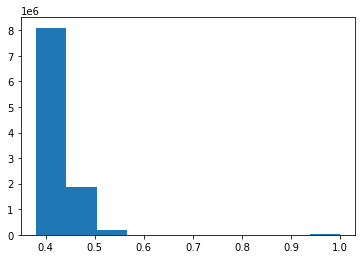

In [278]:
import matplotlib.pyplot as plt

plt.hist(list(map(lambda x: round(x, 2), sim_values_list)))
plt.show()
